# Cats and Dogs Domain Adaptation

This notebook builds on the notebook from the toy example for domain adaptation.

### Import the necessary modules

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None


## Define Training Configurations (args)

In [2]:
dataset_name = "office5"
dataset_fn = office5_get_datasets
num_classes = 5
model_name = "office5"
dimensions = (3,128,128)
workers = 4
batch_size = 16
validation_split = 0.1
log_prefix = "office5_DCD"
log_dir = "jupyter_logging"
data_path = "../Datasets/office5_camera/"
deterministic = True
print_freq = 100
labels = ('back_pack', 'keyboard','laptop_computer','mug','pen')
lr = 0.001

## Define Helper Functions

In [3]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

## Set up the logger

In [4]:
msglogger = apputils.config_pylogger('logging.conf', log_prefix,
                                        log_dir)

# Log various details about the execution environment.  It is sometimes useful
# to refer to past experiment executions and this information may be useful.
apputils.log_execution_env_state(None, msglogger.logdir)
msglogger.debug("Distiller: %s", distiller.__version__)


pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+dataset_name)

tflogger.tblogger.writer.add_text('Command line', "args ---")

msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f',
                dataset_name,dataset_fn,num_classes,model_name,dimensions,batch_size,validation_split,lr)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/office5_DCD___2022.06.29-124651/office5_DCD___2022.06.29-124651.log
dataset_name:office5
dataset_fn=<function office5_get_datasets at 0x7f8ec53ac3a0>
num_classes=5
model_name=office5
dimensions=(3, 128, 128)
batch_size=16
validation_split=0.1
lr=0.001000



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and Load the Datasets

In [5]:
args = Args(act_mode_8bit=False)

In [ ]:
train_set, test_set = office5_get_datasets((data_path, args), load_train=True, load_test=False,apply_transforms=False)

## Visualize a batch of training data

In [ ]:
train_set.visualize_batch()

## Create the data loaders

In [8]:
data_path = "../Datasets/office5"
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(
        dataset_fn, (data_path,args), batch_size,
        workers, validation_split, deterministic,1, 1, 1)
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d',
                   len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)
# train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
# test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=True)

Dataset sizes:
	training=18000
	validation=2000
	test=5000
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.65, 1.35), contrast=(0.65, 1.35), saturation=(0.65, 1.35), hue=None)
    RandomAffine(degrees=[-20.0, 20.0], translate=(0.25, 0.25))
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
)


../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}


## Set up the device, cuda or cpu

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Set up the model for training

In [7]:
ai8x.set_device(device=85, simulate=False, round_avg=False)

model = mod.OfficeClassifier(device=device)
msglogger.info('model: %s',model)
model = model.to(device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/imagenet10_long-train___2022.06.28-172810/imagenet10_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+------------+
| Key                  | Type        | Value      |
|----------------------+-------------+------------|
| arch                 | str         | imagenet10 |
| compression_sched    | dict        |            |
| epoch                | int         | 1855       |
| extras               | dict        |            |
| optimizer_state_dict | dict        |            |
| optimizer_type       | type        | Adam       |
| state_dict           | OrderedDict |            |
+----------------------+-------------+------------+

=> Checkpoint['extras'] contents:
+--------------+--------+----------+
| Key          | Type   |    Value |
|--------------+--------+----------|
| best_epoch   | int    | 1855     |
| best_top1    | float  |   82.981 |
| current_top1 | float  |   82.981 |
+--------------+--------+----------+

L

Configuring device: MAX78000, simulate=False.


=> loaded 'state_dict' from checkpoint 'jupyter_logging/imagenet10_long-train___2022.06.28-172810/imagenet10_qat_best.pth.tar'
/home/geffencooper/Model_Development/ai8x-training/models/minivgg.py:273: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)

model: OfficeClassifier(
  (feature_extractor): Imagenet10Classifier(
    (conv1): FusedConv2dReLU(
      (activate): ReLU(inplace=True)
      (op): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (calc_out_shift): OutputShift()
      (calc_weight_scale): WeightScale()
      (scale): Scaler()
      (calc_out_scale): OutputScale()
      (quantize_weight): Quantize()
      (quantize_bias): Quantize()
      (clamp_weight): Clamp()
      (clamp_bias): Clamp()
      (quantize): Quantize()
      (clamp): Clamp()
      (quantize_pool): Empty()
      (clamp_pool): Empty()
    )
    (conv2): FusedConv2dReLU(
      (activate): ReLU(inplace=

## Set up the training parameters

In [16]:
num_epochs = 200
msglogger.info('epochs: %d',num_epochs)
optimizer = optim.Adam(model.parameters(), lr=lr)
msglogger.info('Optimizer Type: %s', type(optimizer))
ms_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(ms_lr_scheduler.base_lrs)+" milestones: "+str(ms_lr_scheduler.milestones)+ " gamma: "+str(ms_lr_scheduler.gamma))
criterion = torch.nn.CrossEntropyLoss().to(device)

qat_policy = {'start_epoch':10,
              'weight_bits':8}
msglogger.info('qat policy: %s',qat_policy)
compression_scheduler = distiller.CompressionScheduler(model)

epochs: 200
Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({10: 1, 35: 1, 100: 1}) gamma: 0.5
qat policy: {'start_epoch': 10, 'weight_bits': 8}


## Validation Function

In [17]:
def validate(data_loader, model, criterion, loggers, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # keep track of incorrect predictions
    wrong_samples = None
    wrong_preds = None
    actual_preds = None
    img_names = None

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(num_classes, 5)))

    # validation set info
    batch_time = tnt.AverageValueMeter()
    total_samples = len(data_loader.sampler)
    batch_size = data_loader.batch_size
    confusion = tnt.ConfusionMeter(num_classes)
    total_steps = (total_samples + batch_size - 1) // batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, batch_size)

    # Switch to evaluation mode
    model.eval()

    end = time.time()
    class_probs = []
    class_preds = []

    # iterate over the batches in the validation set
    for validation_step, (inputs, target, names) in enumerate(data_loader):
        with torch.no_grad():
            inputs, target = inputs.to(device), target.to(device)
            # compute output from model
            output = model(inputs)

            # correct output for accurate loss calculation
            if args.act_mode_8bit:
                output /= 128.
                for key in model.__dict__['_modules'].keys():
                    if (hasattr(model.__dict__['_modules'][key], 'wide')
                            and model.__dict__['_modules'][key].wide):
                        output /= 256.

            # # get the idxs of the max output
            # pred = output.argmax(dim=1, keepdim=True)
            
            # wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0] # get wrong predictions
            
            # if validation_step == 0:
            #     wrong_samples = inputs[wrong_idx]
            #     wrong_preds = pred[wrong_idx]
            #     actual_preds = target.view_as(pred)[wrong_idx]
            #     img_names = [names[i.item()] for i in wrong_idx] #names[wrong_idx]
            # else:
            #     wrong_samples = torch.cat((wrong_samples,inputs[wrong_idx]),0)
            #     wrong_preds = torch.cat((wrong_preds,pred[wrong_idx]),0)
            #     actual_preds = torch.cat((actual_preds,target.view_as(pred)[wrong_idx]),0)
            #     img_names.extend([names[i.item()] for i in wrong_idx])

            # compute loss
            loss = criterion(output, target)

            # measure accuracy and record loss
            losses['objective_loss'].add(loss.item())
            if len(output.data.shape) <= 2:
                classerr.add(output.data, target)
            else:
                classerr.add(output.data.permute(0, 2, 3, 1).flatten(start_dim=0, end_dim=2),
                                target.flatten())
            
            confusion.add(output.data, target)

            # measure elapsed time
            batch_time.add(time.time() - end)
            end = time.time()

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                _, class_preds_batch = torch.max(output, 1)
                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Loss', losses['objective_loss'].mean),
                                    ('Top1', classerr.value(1))])
                )
                if num_classes > 5:
                    stats[1]['Top5'] = classerr.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed,
                                                total_steps, print_freq, loggers)


                # if tflogger is not None:
                #     test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
                #     test_preds = torch.cat(class_preds)
                #     for i in range(num_classes):
                #         tb_preds = test_preds == i
                #         tb_probs = test_probs[:, i]
                #         tflogger.tblogger.writer.add_pr_curve(str(args.labels[i]), tb_preds,
                #                                             tb_probs, global_step=epoch)

                # if steps_completed == total_steps and tflogger is not None:
                #     def select_n_random(data, labels, features, n=100):
                #         """Selects n random datapoints, their corresponding labels and features"""
                #         assert len(data) == len(labels) == len(features)

                #         perm = torch.randperm(len(data))
                #         return data[perm][:n], labels[perm][:n], features[perm][:n]

                #     # Select up to 100 random images and their target indices
                #     images, labels, features = select_n_random(inputs, target, output,
                #                                                n=min(100, len(inputs)))

                #     # Get the class labels for each image
                #     class_labels = [args.labels[lab] for lab in labels]

                #     tflogger.tblogger.writer.add_embedding(
                #         features,
                #         metadata=class_labels,
                #         label_img=args.visualize_fn(images, args),
                #         global_step=epoch,
                #         tag='verification/embedding'
                #     )

    if num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n',
                        classerr.value()[0], classerr.value()[1],
                        losses['objective_loss'].mean)
    else:
        msglogger.info('==> Top1: %.3f    Loss: %.3f\n',
                        classerr.value()[0], losses['objective_loss'].mean)

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
    # if epoch > 0:
    #     data_loader.dataset.viz_mispredict(wrong_samples,wrong_preds,actual_preds,img_names)
    return classerr.value(1), classerr.value(min(num_classes, 5)), losses['objective_loss'].mean

## Run the training loop

In [ ]:
# store model history across epochs
perf_scores_history = []
model = model.to(device)

name = model_name

# start the clock
tic = datetime.now()

# training loop
for epoch in range(0, num_epochs):
    # check if need to switch to QAT
    if epoch > 0 and epoch == qat_policy['start_epoch']:
        print('QAT is starting!')
        # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
        ai8x.fuse_bn_layers(model)

        # Switch model from unquantized to quantized for QAT
        ai8x.initiate_qat(model, qat_policy)

        # Model is re-transferred to GPU in case parameters were added
        model.to(device)

        # Empty the performance scores list for QAT operation
        perf_scores_history = []
        name = f'{model_name}_qat'

    # store loss and training stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(num_classes, 5)))
    batch_time = tnt.AverageValueMeter()
    data_time = tnt.AverageValueMeter()

    # logging stats
    total_samples = len(train_loader.sampler)
    batch_size = train_loader.batch_size
    steps_per_epoch = (total_samples + batch_size - 1) // batch_size
    msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, batch_size)

    # Switch to train mode
    model.train()
    acc_stats = []
    end = time.time()

    # iterate over all batches in the dataset
    for train_step, (inputs, target, names) in enumerate(train_loader):
        # Measure data loading time
        data_time.add(time.time() - end)
        inputs, target = inputs.to(device), target.to(device)

        # forward pass and loss calculation
        output = model(inputs)
        loss = criterion(output, target)

        # on the last batch store the stats for the epoch
        if train_step >= len(train_loader)-2:
            if len(output.data.shape) <= 2:
                classerr.add(output.data, target)
            else:
                classerr.add(output.data.permute(0, 2, 3, 1).flatten(start_dim=0, end_dim=2),
                                target.flatten())
            acc_stats.append([classerr.value(1), classerr.value(min(num_classes, 5))])

        # add the loss for each batch
        losses["objective_loss"].add(loss.item())

        # reset the optimizer
        optimizer.zero_grad()

        # backwards pass and parameter update
        loss.backward()
        optimizer.step()

        # track batch stats
        batch_time.add(time.time() - end)
        steps_completed = (train_step+1)

        # log stats every 10 batches
        if steps_completed % print_freq == 0 or steps_completed == steps_per_epoch:
            # Log some statistics
            errs = OrderedDict()
            if classerr.n != 0:
                errs['Top1'] = classerr.value(1)
                if num_classes > 5:
                    errs['Top5'] = classerr.value(5)
            else:
                errs['Top1'] = None
                errs['Top5'] = None

            stats_dict = OrderedDict()
            for loss_name, meter in losses.items():
                stats_dict[loss_name] = meter.mean
            stats_dict.update(errs)
            
            stats_dict['LR'] = optimizer.param_groups[0]['lr']
            stats_dict['Time'] = batch_time.mean
            stats = ('Performance/Training/', stats_dict)
            params = None
            distiller.log_training_progress(stats,
                                            params,
                                            epoch, steps_completed,
                                            steps_per_epoch, print_freq,
                                            all_loggers)
        end = time.time()



    # after a training epoch, do validation
    msglogger.info('--- validate (epoch=%d)-----------', epoch)
    top1, top5, vloss = validate(val_loader, model, criterion, [pylogger], epoch, tflogger)

    # store validation stats
    stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
    if num_classes > 5:
        stats[1]['Top5'] = top5

    distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                            log_freq=1, loggers=all_tbloggers)

    perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                            'epoch': epoch}))
    # Keep perf_scores_history sorted from best to worst
    # Sort by top1 as main sort key, then sort by top5 and epoch
    perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
    for score in perf_scores_history[:1]:
        if num_classes > 5:
            msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                            score.top1, score.top5,score.epoch)
        else:
            msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                            score.top1, score.epoch)

    # Save the checkpoint
    is_best = epoch == perf_scores_history[0].epoch
    checkpoint_extras = {'current_top1': top1,
                        'best_top1': perf_scores_history[0].top1,
                        'best_epoch': perf_scores_history[0].epoch}

    apputils.save_checkpoint(epoch, model_name, model, optimizer=optimizer,
                                scheduler=compression_scheduler, extras=checkpoint_extras,
                                is_best=is_best, name=name,
                                dir=msglogger.logdir)

    ms_lr_scheduler.step()

# Finally run results on the test set
top1, top5, losses = validate(test_loader, model, criterion, [pylogger],epoch,None)
msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)

msglogger.info('Training time: %s', datetime.now() - tic)

## Next train the Domain-Class Discriminator

### Set up the discriminator

In [13]:
# load the encoder-classifier model
load_model_path = "jupyter_logging/office5-fine_tune___2022.06.29-104825/office5_qat_best.pth.tar"
model = mod.OfficeClassifier(device=device)                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

# register a forward hook to get the encoder output
encoder_output = {}
def get_embedding(name):
    def hook(model, input, output):
        encoder_output[name] = output.detach()
    return hook

# get the activations
model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))

# create the discriminator
discriminator = mod.OfficeDCD()
discriminator = discriminator.to(device)

=> loading checkpoint jupyter_logging/imagenet10_long-train___2022.06.28-172810/imagenet10_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+------------+
| Key                  | Type        | Value      |
|----------------------+-------------+------------|
| arch                 | str         | imagenet10 |
| compression_sched    | dict        |            |
| epoch                | int         | 1855       |
| extras               | dict        |            |
| optimizer_state_dict | dict        |            |
| optimizer_type       | type        | Adam       |
| state_dict           | OrderedDict |            |
+----------------------+-------------+------------+

=> Checkpoint['extras'] contents:
+--------------+--------+----------+
| Key          | Type   |    Value |
|--------------+--------+----------|
| best_epoch   | int    | 1855     |
| best_top1    | float  |   82.981 |
| current_top1 | float  |   82.981 |
+--------------+--------+----------+

L

In [14]:
X_s,Y_s = create_source_samples("../Datasets/office5/",args)
X_t,Y_t = create_target_samples(4,"../Datasets/office5_camera/",args)

../Datasets/office5/train
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}
../Datasets/office5_camera/train
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}


In [15]:
#-----------------train DCD for step 2--------------------------------

optimizer_D=torch.optim.Adam(discriminator.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [17]:
epoch_loss = []
for epoch in range(400):
    # data
    groups,aa = create_groups(X_s,Y_s,X_t,Y_t,shot=4,seed=epoch)

    n_iters = 4 * len(groups[1])
    index_list = torch.randperm(n_iters)
    mini_batch_size=32 #use mini_batch train can be more stable


    loss_mean=[]

    X1=[];X2=[];ground_truths=[]
    for index in range(n_iters):
                            #    0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
        # get the class idx --> [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
        ground_truth=index_list[index]//len(groups[1])
        # get the pair by indexing into the groups
        # the first index is the group, the second index is the relative location within the class
        # e.g. idx 5 is the 1st element in class 1 for the example above
        x1,x2=groups[ground_truth][index_list[index]-len(groups[1])*ground_truth]
        X1.append(x1)
        X2.append(x2)
        ground_truths.append(ground_truth)

        #select data for a mini-batch to train
        if (index+1)%mini_batch_size==0:
            X1=torch.stack(X1)
            X2=torch.stack(X2)
            ground_truths=torch.LongTensor(ground_truths)
            X1=X1.to(device)
            X2=X2.to(device)
            ground_truths=ground_truths.to(device)

            optimizer_D.zero_grad()
            out1 = model(X1)
            enc1 = encoder_output['fc2']
            out2 = model(X2)
            enc2 = encoder_output['fc2']
            X_cat=torch.cat([enc1,enc2],1)
            y_pred=discriminator(X_cat.detach())
            #print(torch.sum(y_pred.argmax(dim=1)==ground_truths)/mini_batch_size)
            loss=loss_fn(y_pred,ground_truths)
            loss.backward()
            optimizer_D.step()
            loss_mean.append(loss.item())
            X1 = []
            X2 = []
            ground_truths = []

    print("step2----Epoch %d/%d loss:%.3f"%(epoch+1,200,np.mean(loss_mean)))
    epoch_loss.append(np.mean(loss_mean))


step2----Epoch 1/200 loss:1.695
step2----Epoch 2/200 loss:1.590
step2----Epoch 3/200 loss:1.546
step2----Epoch 4/200 loss:1.426
step2----Epoch 5/200 loss:1.355
step2----Epoch 6/200 loss:1.330
step2----Epoch 7/200 loss:1.294
step2----Epoch 8/200 loss:1.217
step2----Epoch 9/200 loss:1.221
step2----Epoch 10/200 loss:1.233
step2----Epoch 11/200 loss:1.167
step2----Epoch 12/200 loss:1.143
step2----Epoch 13/200 loss:1.159
step2----Epoch 14/200 loss:1.140
step2----Epoch 15/200 loss:1.073
step2----Epoch 16/200 loss:1.044
step2----Epoch 17/200 loss:1.047
step2----Epoch 18/200 loss:1.103
step2----Epoch 19/200 loss:0.995
step2----Epoch 20/200 loss:0.987
step2----Epoch 21/200 loss:1.010
step2----Epoch 22/200 loss:0.966
step2----Epoch 23/200 loss:1.006
step2----Epoch 24/200 loss:0.956
step2----Epoch 25/200 loss:0.856
step2----Epoch 26/200 loss:0.859
step2----Epoch 27/200 loss:0.905
step2----Epoch 28/200 loss:0.844
step2----Epoch 29/200 loss:0.865
step2----Epoch 30/200 loss:0.871
step2----Epoch 31/2

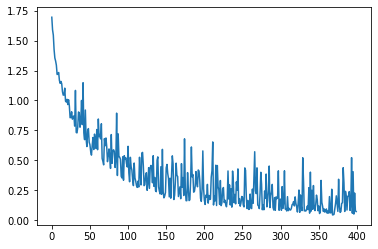

In [18]:
plt.plot(epoch_loss)

## Now we do adversarial training to trick the discriminator

In [19]:
train_set, test_set = office5_get_datasets(("../Datasets/office5_camera/", args), load_train=False, load_test=True,apply_transforms=False)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

../Datasets/office5_camera/test
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}


In [26]:
#-------------------training for step 3-------------------
optimizer_g_h=torch.optim.Adam(model.parameters(),lr=0.002)
optimizer_d=torch.optim.Adam(discriminator.parameters(),lr=0.002)


for epoch in range(20):
    #---training g and h , DCD is frozen

    groups, groups_y = sample_groups(X_s,Y_s,X_t,Y_t,shot=4,seed=200+epoch)
    G1, G2, G3, G4 = groups
    Y1, Y2, Y3, Y4 = groups_y
    groups_2 = [G2, G4]
    groups_y_2 = [Y2, Y4]

    n_iters = 2 * len(G2)
    index_list = torch.randperm(n_iters)

    n_iters_dcd = 4 * len(G2)
    index_list_dcd = torch.randperm(n_iters_dcd)

    mini_batch_size_g_h = 16 #data only contains G2 and G4 ,so decrease mini_batch
    mini_batch_size_dcd= 32 #data contains G1,G2,G3,G4 so use 40 as mini_batch
    X1 = []
    X2 = []
    ground_truths_y1 = []
    ground_truths_y2 = []
    dcd_labels=[]
    for index in range(n_iters):
        ground_truth=index_list[index]//len(G2)
        x1, x2 = groups_2[ground_truth][index_list[index] - len(G2) * ground_truth]
        y1, y2 = groups_y_2[ground_truth][index_list[index] - len(G2) * ground_truth]
        # y1=torch.LongTensor([y1.item()])
        # y2=torch.LongTensor([y2.item()])
        dcd_label=0 if ground_truth==0 else 2
        X1.append(x1)
        X2.append(x2)
        ground_truths_y1.append(y1)
        ground_truths_y2.append(y2)
        dcd_labels.append(dcd_label)

        if (index+1)%mini_batch_size_g_h==0:
            print("train 1")
            X1=torch.stack(X1)
            X2=torch.stack(X2)
            ground_truths_y1=torch.LongTensor(ground_truths_y1)
            ground_truths_y2 = torch.LongTensor(ground_truths_y2)
            dcd_labels=torch.LongTensor(dcd_labels)
            X1=X1.to(device)
            X2=X2.to(device)
            ground_truths_y1=ground_truths_y1.to(device)
            ground_truths_y2 = ground_truths_y2.to(device)
            dcd_labels=dcd_labels.to(device)

            optimizer_g_h.zero_grad()

            out1 = model(X1)
            enc1 = encoder_output['fc2']
            out2 = model(X2)
            enc2 = encoder_output['fc2']

            X_cat=torch.cat([enc1,enc2],1)
            y_pred_X1=out1
            y_pred_X2=out2
            y_pred_dcd=discriminator(X_cat)

            loss_X1=loss_fn(y_pred_X1,ground_truths_y1)
            loss_X2=loss_fn(y_pred_X2,ground_truths_y2)
            loss_dcd=loss_fn(y_pred_dcd,dcd_labels)

            loss_sum = loss_X1 + loss_X2 + 0.2 * loss_dcd

            loss_sum.backward()
            optimizer_g_h.step()

            X1 = []
            X2 = []
            ground_truths_y1 = []
            ground_truths_y2 = []
            dcd_labels = []


    #----training dcd ,g and h frozen
    X1 = []
    X2 = []
    ground_truths = []
    for index in range(n_iters_dcd):

        ground_truth=index_list_dcd[index]//len(groups[1])

        x1, x2 = groups[ground_truth][index_list_dcd[index] - len(groups[1]) * ground_truth]
        X1.append(x1)
        X2.append(x2)
        ground_truths.append(ground_truth)

        if (index + 1) % mini_batch_size_dcd == 0:
            print("train 2")
            X1 = torch.stack(X1)
            X2 = torch.stack(X2)
            ground_truths = torch.LongTensor(ground_truths)
            X1 = X1.to(device)
            X2 = X2.to(device)
            ground_truths = ground_truths.to(device)

            optimizer_d.zero_grad()

            out1 = model(X1)
            enc1 = encoder_output['fc2']
            out2 = model(X2)
            enc2 = encoder_output['fc2']
            X_cat = torch.cat([enc1, enc2], 1)
            y_pred = discriminator(X_cat.detach())
            loss = loss_fn(y_pred, ground_truths)
            loss.backward()
            optimizer_d.step()
            # loss_mean.append(loss.item())
            X1 = []
            X2 = []
            ground_truths = []

    #testing
    acc = 0
    for data, labels,names in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        y_test_pred = model(data)
        acc += (torch.max(y_test_pred, 1)[1] == labels).float().mean().item()

    accuracy = round(acc / float(len(test_dataloader)), 3)

    print("step3----Epoch %d/%d  accuracy: %.3f " % (epoch + 1, 50, accuracy))

Sampling groups
train 1
train 2
step3----Epoch 1/50  accuracy: 0.271 
Sampling groups
train 1
train 2
step3----Epoch 2/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 3/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 4/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 5/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 6/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 7/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 8/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 9/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 10/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 11/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 12/50  accuracy: 0.333 
Sampling groups
train 1
train 2
step3----Epoch 13/50  accuracy: 0.312 
Sampling groups
train 1
train 2
step3----Epoch 14/50  accuracy: 0.312 
Sampling groups

In [28]:
# grab the test batch
test_batch_path = "../Datasets/office5_both/"
#args = Args(act_mode_8bit=True)
_, test_set = cats_and_dogs_get_datasets((test_batch_path, args), load_train=False, load_test=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

# get a batch of data
(batch_imgs, batch_labels, names) = next(iter(test_loader))
batch_imgs,batch_labels = batch_imgs.to(device), batch_labels.to(device)

# register forward hook to get embedding output
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# get the activations
model.eval()
model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
preds = model(batch_imgs)
embds = activation['fc1']

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    if label.item() == 0:
        batch_label_strings.append("pen_camera")
    elif label.item() == 1:
        batch_label_strings.append("keyboard_dataset")
    elif label.item() == 2:
        batch_label_strings.append("backpack_camera")
    elif label.item() == 3:
        batch_label_strings.append("laptop_dataset")
    elif label.item() == 4:
        batch_label_strings.append("mug_dataset")
    elif label.item() == 5:
        batch_label_strings.append("pen_dataset")
    elif label.item() == 6:
        batch_label_strings.append("laptop_camera")
    elif label.item() == 7:
        batch_label_strings.append("keyboard_camera")
    elif label.item() == 8:
        batch_label_strings.append("backpack_dataset")
    elif label.item() == 9:
        batch_label_strings.append("mug_camera")

# log to tensorboard
tflogger.tblogger.writer.add_embedding(
        embds.to('cpu'),
        #metadata=batch_names,
        metadata=batch_label_strings,
        label_img=batch_imgs.to('cpu'),
        global_step=0
    )

../Datasets/office5_both/test
{'pen_camera': 0, 'keyboard_dataset': 1, 'backpack_camera': 2, 'laptop_dataset': 3, 'mug_dataset': 4, 'pen_dataset': 5, 'laptop_camera': 6, 'keyboard_camera': 7, 'backpack_dataset': 8, 'mug_camera': 9}


In [110]:
# grab the test batch
test_batch_path = "../Datasets/test_batch/"
#args = Args(act_mode_8bit=True)
_, test_set = cats_and_dogs_get_datasets((test_batch_path, args), load_train=False, load_test=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


# get a batch of data
(batch_imgs, batch_labels, names) = next(iter(test_loader))
batch_imgs,batch_labels = batch_imgs.to(device), batch_labels.to(device)

# register forward hook to get embedding output
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# get the activations
model.eval()
model.fc1.register_forward_hook(get_activation('fc1'))
preds = model(batch_imgs)
embds = activation['fc1']

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    if label.item() == 0:
        batch_label_strings.append("dog")
    elif label.item() == 1:
        batch_label_strings.append("cat")

# log to tensorboard
tflogger.tblogger.writer.add_embedding(
        embds.to('cpu'),
        #metadata=batch_names,
        metadata=batch_label_strings,
        label_img=batch_imgs.to('cpu'),
        global_step=0
    )

../Datasets/test_batch/test
{'dogs': 0, 'cats': 1}


In [111]:
np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/64

0.8125